In [1]:
import os

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import shutil
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set the random seeds

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
%%capture
image_dir = './Data/'
data_dir = './'

train_size = 0.8
val_size = 0.2

for root, dirs, files in os.walk(image_dir):
    if len(files) > 0:
        train_files, val_files = train_test_split(files, test_size=(1 - train_size), random_state=42)
        for split_name,files in zip(["train","val"],[train_files,val_files]):
            output_dir = os.path.join(data_dir, split_name, os.path.relpath(root, image_dir))
            os.makedirs(output_dir, exist_ok=True)
            for file in files:
                src = os.path.join(root, file)
                dst = os.path.join(output_dir, file)
                shutil.move(src, dst)

In [4]:
#train and validation transforms
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

train_set = torchvision.datasets.ImageFolder("train", transform=train_transform)
val_set = torchvision.datasets.ImageFolder("val", transform=val_transform)

# Define data loaders
train_loader = DataLoader(train_set,batch_size=64,shuffle=True)
val_loader = DataLoader(val_set,batch_size=64,shuffle=False)

Train set
glioma: 720 / meningioma: 730 /normal: 350 / pituitary: 675


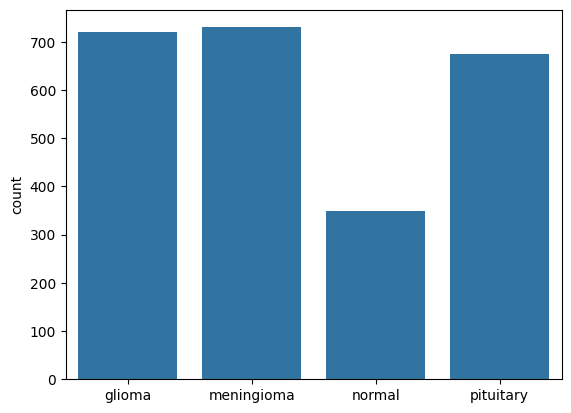

In [5]:
# train set distribution
counter = []
x_g = 0
x_m = 0
x_n = 0
x_p = 0

for i in train_set:
    if i[1] == 0:
        counter.append("glioma")
        x_g += 1
    elif i[1] == 1:
        counter.append("meningioma")
        x_m += 1
    elif i[1] == 2:
        counter.append("normal")
        x_n += 1
    else:
        counter.append("pituitary")
        x_p += 1

print('Train set')
print('glioma:', x_g, '/ meningioma:', x_m,'/normal:', x_n, '/ pituitary:', x_p)
sns.countplot(x=counter);

Train set
glioma: 181 / meningioma: 183 /normal: 88 / pituitary: 169


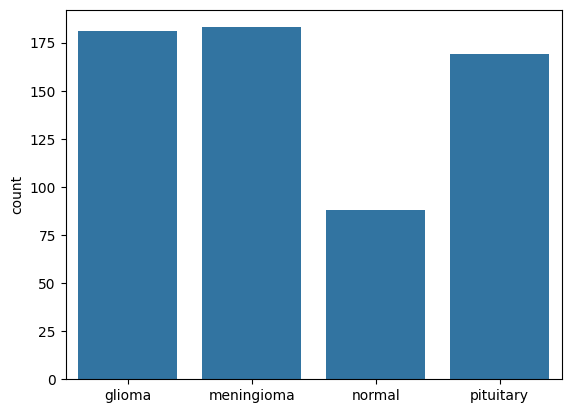

In [6]:
# validation set distribution
counter = []
x_g = 0
x_m = 0
x_n = 0
x_p = 0

for i in val_set:
    if i[1] == 0:
        counter.append("glioma")
        x_g += 1
    elif i[1] == 1:
        counter.append("meningioma")
        x_m += 1
    elif i[1] == 2:
        counter.append("normal")
        x_n += 1
    else:
        counter.append("pituitary")
        x_p += 1

print('Train set')
print('glioma:', x_g, '/ meningioma:', x_m,'/normal:', x_n, '/ pituitary:', x_p)
sns.countplot(x=counter);

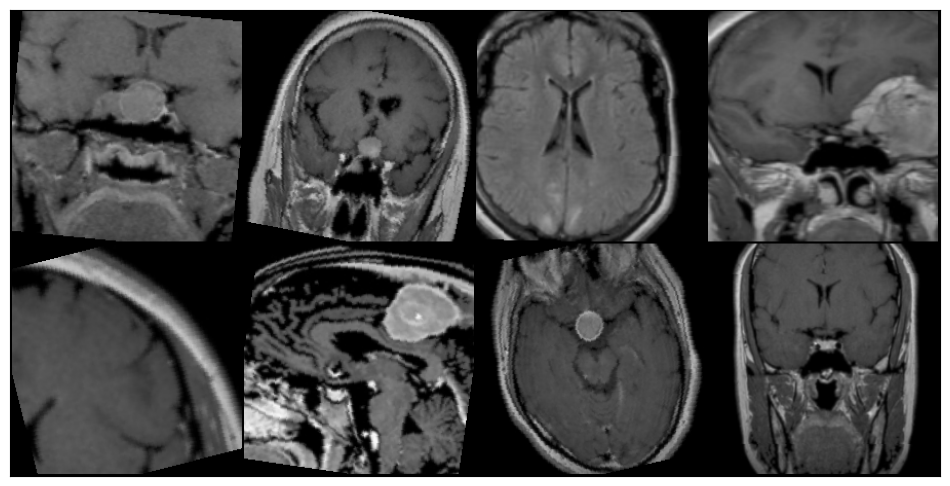

In [7]:
stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dltrain_loader):
    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(torchvision.utils.make_grid(denorm_images[:8], nrow=4).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(train_loader)

In [8]:
# Load pretrained  ResNet18 model
model = models.vgg16(pretrained=True)

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\srbil/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [14:59<00:00, 615kB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

metrics = {
    'train': {
         'loss': [], 'accuracy': []
    },
    'val': {
         'loss': [], 'accuracy': []
    },
}

#Train model
train_loss=[]
train_accuary=[]
valid_loss=[]
valid_accuary=[]

num_epochs = 20   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        # forward inputs and get output
        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()
            outputs=model(image)
            _, preds = torch.max(outputs, 1)
            loss=criterion(outputs,label)
            if loss.requires_grad:
                loss.backward()
            return loss
        optimizer.step(closure)
        # only for diagnostics
        outputs=model(image)
        loss=criterion(outputs,label)
        _, preds = torch.max(outputs, 1)
        #running_loss +=loss.data.item()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == label.data).item()
    epoch_loss = running_loss / len(train_set)
    epoch_acc = running_corrects / len(train_set) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, label)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == label.data).item()
        epoch_loss = running_loss / len(val_set)
        epoch_acc = running_corrects / len(val_set) * 100.
        # Append result
        valid_loss.append(epoch_loss)
        valid_accuary.append(epoch_acc)
        # Print progress
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0138 Acc: 63.2727% Time: 627.4572s
[Validation #1] Loss: 0.0075 Acc: 82.1256% Time: 649.8122s
Epoch 1 running
[Train #2] Loss: 0.0084 Acc: 79.7172% Time: 1370.9314s
[Validation #2] Loss: 0.0070 Acc: 84.5411% Time: 1407.5444s
Epoch 2 running
[Train #3] Loss: 0.0067 Acc: 84.2020% Time: 2184.6864s
[Validation #3] Loss: 0.0045 Acc: 89.0499% Time: 2227.5324s
Epoch 3 running
[Train #4] Loss: 0.0067 Acc: 83.7576% Time: 3074.0799s
[Validation #4] Loss: 0.0044 Acc: 90.4992% Time: 3116.5809s
Epoch 4 running
[Train #5] Loss: 0.0052 Acc: 87.6768% Time: 3873.4589s
[Validation #5] Loss: 0.0031 Acc: 93.8808% Time: 3910.3709s
Epoch 5 running
[Train #6] Loss: 0.0045 Acc: 89.7374% Time: 4732.1713s
[Validation #6] Loss: 0.0027 Acc: 94.3639% Time: 4769.1490s
Epoch 6 running
[Train #7] Loss: 0.0039 Acc: 90.5051% Time: 5401.4735s
[Validation #7] Loss: 0.0031 Acc: 93.5588% Time: 5431.3988s
Epoch 7 running
[Train #8] Loss: 0.0038 Acc: 91.2323% Time: 6094.9016s
[Validation #8

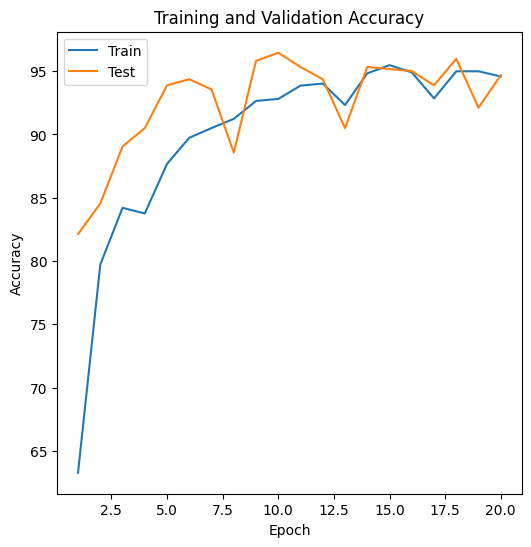

In [10]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary)
plt.plot(np.arange(1,num_epochs+1), valid_accuary)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Training and Validation Accuracy')
plt.show()

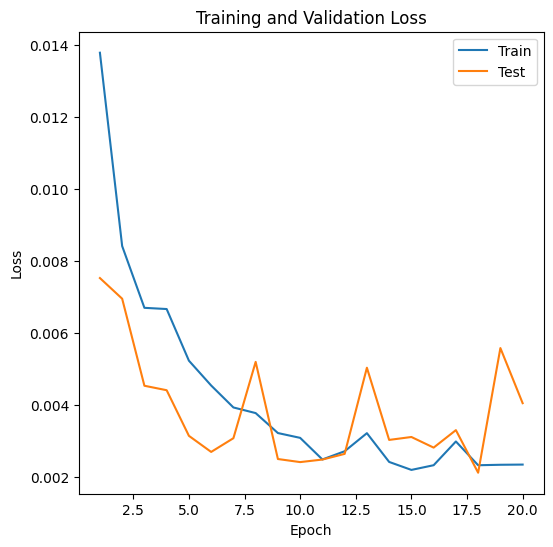

In [11]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_loss)
plt.plot(np.arange(1,num_epochs+1), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Training and Validation Loss')
plt.show()

In [12]:
y_true = []
y_pred = []

for data in val_loader:
    image,label=data[0].to(device),data[1]
    y_true.extend(label.numpy())

    outputs=model(image)

    _, predicted = torch.max(outputs, 1)
    y_pred.extend(predicted.cpu().numpy())

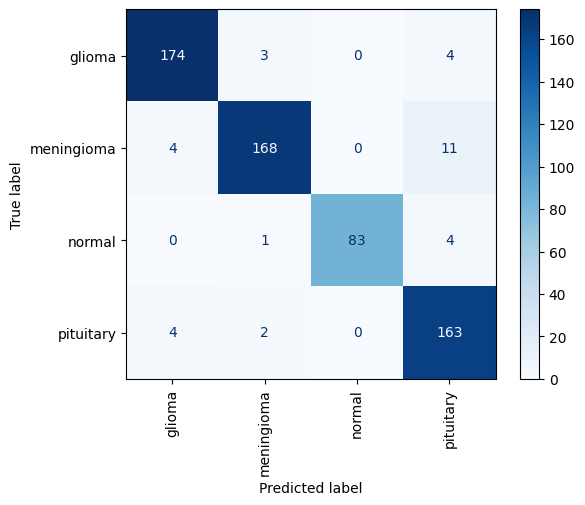

In [13]:
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = ['glioma','meningioma', 'normal', 'pituitary']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues,xticks_rotation="vertical")
plt.show()

In [14]:
# Generate a classification report
  
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       181
           1       0.97      0.92      0.94       183
           2       1.00      0.94      0.97        88
           3       0.90      0.96      0.93       169

    accuracy                           0.95       621
   macro avg       0.95      0.95      0.95       621
weighted avg       0.95      0.95      0.95       621

